# SURE Kickoff Talk May 22, 2023

Computations and figures presented on Monday, May 22, 2023, [slides here](https://speakerdeck.com/fjhickernell/how-much-to-sample-to-estimate-the-mean)

To run this notebook you need to pip install

    • qmcpy
    • sympy
    • docker

## Import the necessary packages and set up plotting routines

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as Nintegrate
import qmcpy as qp
#from sympy import * #so that we can do symbolic integration; not required for this notebook
import time  #timing routines
import warnings  #to suppress warnings when needed
import pickle  #write output to a file and load it back in
from copy import deepcopy
from matplotlib.patches import Polygon

np.set_printoptions(threshold=10)

plt.rc('font', size=16)  #set defaults so that the plots are readable
plt.rc('font', serif = "Computer Modern Roman")
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb,bm}')
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=16)

#a helpful plotting method to show increasing numbers of points
def plot_successive_points(distrib,ld_name,first_n=64,n_cols=1,
                           pt_clr=['tab:blue', 'tab:orange', 'k', 'tab:cyan', 'tab:purple', 'tab:orange'],
                           xlim=[0,1],ylim=[0,1],ntitle=True,titleText='',
                          coordlist=[[0,1]],nrep=1):
  fig,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(5*n_cols,5.5))
  if n_cols==1: ax = [ax]
  last_n = first_n*(2**n_cols)
  if isinstance(distrib, list):
    nrep = len(distrib)
  else:
    nrep = 1
  if nrep==1: points = distrib.gen_samples(n=last_n)
  ncoord = len(coordlist)
  for i in range(n_cols):
    n = first_n
    nstart = 0
    if nrep > 1:
      points = distrib[i].gen_samples(n=last_n)
      ax[i].scatter(points[nstart:n,0],points[nstart:n,1],color=pt_clr[0])
      ax[i].set_xlim(xlim); ax[i].set_xticks(xlim); ax[i].set_xlabel('$x_{i,'+str(coordlist[0][0]+1)+'}$')
      ax[i].set_ylim(ylim); ax[i].set_yticks(ylim); ax[i].set_ylabel('$x_{i,'+str(coordlist[0][1]+1)+'}$')
    elif ncoord >1:
      ax[i].scatter(points[nstart:n,coordlist[i][0]],points[nstart:n,coordlist[i][1]],color=pt_clr[0])
      ax[i].set_xlim(xlim); ax[i].set_xticks(xlim); ax[i].set_xlabel('$x_{i,'+str(coordlist[i][0]+1)+'}$')
      ax[i].set_ylim(ylim); ax[i].set_yticks(ylim); ax[i].set_ylabel('$x_{i,'+str(coordlist[i][1]+1)+'}$')
    else:
      for j in range(i+1):
        n = first_n*(2**j)
        ax[i].scatter(points[nstart:n,0],points[nstart:n,1],color=pt_clr[j])
        nstart = n
        if ntitle == True:
          ax[i].set_title('n = %d'%n)
        else:
          ax[i].set_title(titleText)
        ax[i].set_xlabel('$x_{i,'+str(coordlist[0][0]+1)+'}$')
        ax[i].set_ylabel('$x_{i,'+str(coordlist[0][1]+1)+'}$')
    ax[i].set_xlim(xlim); ax[i].set_xticks(xlim)
    ax[i].set_ylim(ylim); ax[i].set_yticks(ylim)
    ax[i].set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
  if ld_name != "":
    fig.suptitle('%s Points'%ld_name, y=0.87)
  return fig
print('QMCPy Version',qp.__version__)


QMCPy Version 1.4


### Set the path to save the figures here

In [2]:
figpath = '' #this path sends the figures to the directory that you want

## Beam Example Figures

Using computations done below

### Plot the time and sample size required to solve for the deflection of the end point using IID and low discrepancy 

[1037.12106673]


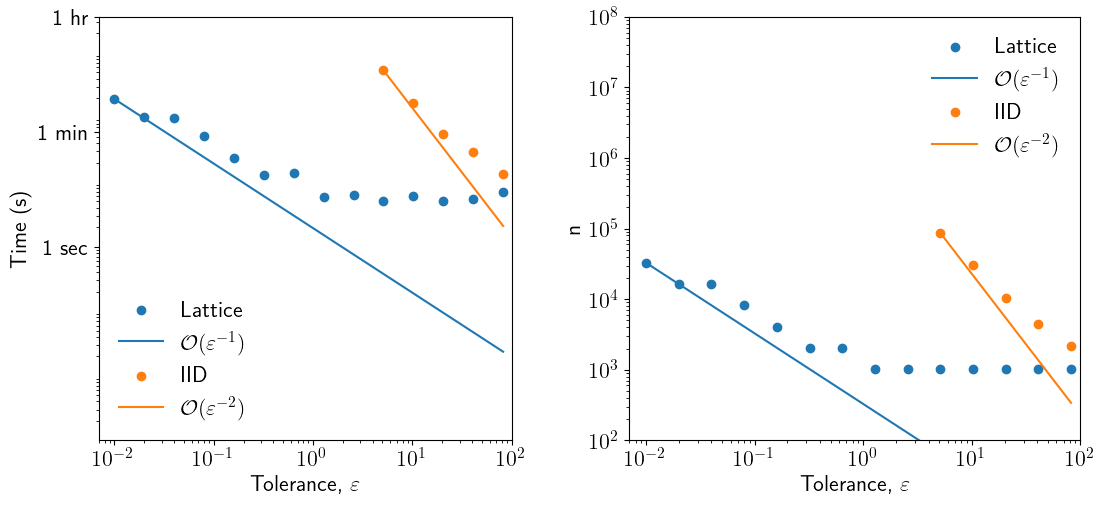

In [3]:
with open(figpath+'iid_ld.pkl','rb') as myfile: tol_vec,n_tol,ii_iid,ld_time,ld_n,iid_time,iid_n,best_solution_i = pickle.load(myfile)
print(best_solution_i)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5.5))
ax[0].scatter(tol_vec[0:n_tol],ld_time[0:n_tol],color='tab:blue'); 
ax[0].plot(tol_vec[0:n_tol],[(ld_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:blue')
ax[0].scatter(tol_vec[ii_iid:n_tol],iid_time[ii_iid:n_tol],color='tab:orange'); 
ax[0].plot(tol_vec[ii_iid:n_tol],[(iid_time[ii_iid]*(tol_vec[ii_iid]**2))/(tol_vec[jj]**2) for jj in range(ii_iid,n_tol)],color='tab:orange')
ax[0].set_ylim([0.001,1000]); ax[0].set_ylabel('Time (s)')
ax[1].scatter(tol_vec[0:n_tol],ld_n[0:n_tol],color='tab:blue'); 
ax[1].plot(tol_vec[0:n_tol],[(ld_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:blue')
ax[1].scatter(tol_vec[ii_iid:n_tol],iid_n[ii_iid:n_tol],color='tab:orange'); 
ax[1].plot(tol_vec[ii_iid:n_tol],[(iid_n[ii_iid]*(tol_vec[ii_iid]**2))/(tol_vec[jj]**2) for jj in range(ii_iid,n_tol)],color='tab:orange')
ax[1].set_ylim([1e2,1e8]); ax[1].set_ylabel('n')
for ii in range(2):
  ax[ii].set_xlim([0.007,100]); ax[ii].set_xlabel('Tolerance, '+r'$\varepsilon$')
  ax[ii].set_xscale('log'); ax[ii].set_yscale('log')
  ax[ii].legend(['Lattice',r'$\mathcal{O}(\varepsilon^{-1})$','IID',r'$\mathcal{O}(\varepsilon^{-2})$'],frameon=False)
  ax[ii].set_aspect(0.65)
ax[0].set_yticks([1, 60, 3600], labels = ['1 sec', '1 min', '1 hr'])    
fig.savefig(figpath+'iidldbeam.eps',format='eps',bbox_inches='tight')

### Plot the time and sample size required to solve for the deflection of the whole beam using low discrepancy with and without parallel

[1037.12106673]


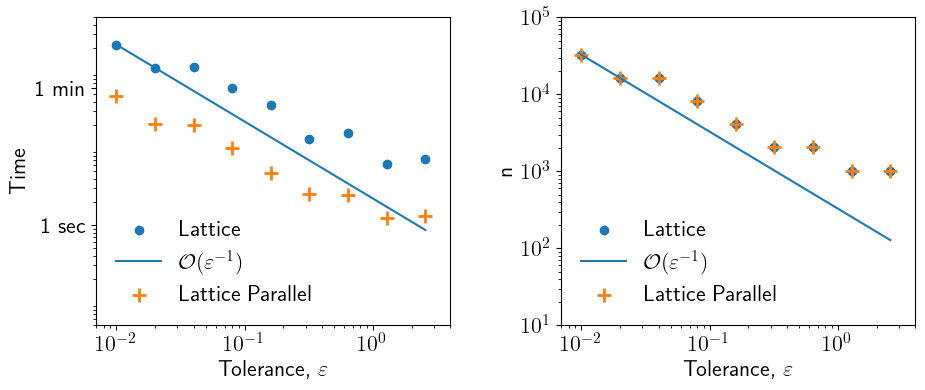

In [4]:
with open(figpath+'ld_parallel.pkl','rb') as myfile: tol_vec,n_tol,ld_time,ld_n,ld_p_time,ld_p_n,best_solution = pickle.load(myfile)
print(best_solution_i)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))
ax[0].scatter(tol_vec[0:n_tol],ld_time[0:n_tol],color='tab:blue'); 
ax[0].plot(tol_vec[0:n_tol],[(ld_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:blue')
ax[0].scatter(tol_vec[0:n_tol],ld_p_time[0:n_tol],color='tab:orange',marker = '+',s=100,linewidths=2); 
#ax[0].plot(tol_vec[0:n_tol],[(ld_p_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:orange')
ax[0].set_ylim([0.05,500]); ax[0].set_ylabel('Time')
ax[1].scatter(tol_vec[0:n_tol],ld_n[0:n_tol],color='tab:blue'); 
ax[1].plot(tol_vec[0:n_tol],[(ld_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:blue')
ax[1].scatter(tol_vec[0:n_tol],ld_p_n[0:n_tol],color='tab:orange',marker = '+',s=100,linewidths=2); 
#ax[1].plot(tol_vec[0:n_tol],[(ld_p_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='tab:orange')
ax[1].set_ylim([10,1e5]); ax[1].set_ylabel('n')
for ii in range(2):
  ax[ii].set_xlim([0.007,4]); ax[ii].set_xlabel('Tolerance, '+r'$\varepsilon$')
  ax[ii].set_xscale('log'); ax[ii].set_yscale('log')
  ax[ii].legend(['Lattice',r'$\mathcal{O}(\varepsilon^{-1})$','Lattice Parallel',r'$\mathcal{O}(\varepsilon^{-1})$'],frameon=False)
  ax[ii].set_aspect(0.6)
ax[0].set_yticks([1, 60], labels = ['1 sec', '1 min'])
fig.savefig(figpath+'ldparallelbeam.eps',format='eps',bbox_inches='tight')

### Plot of beam solution

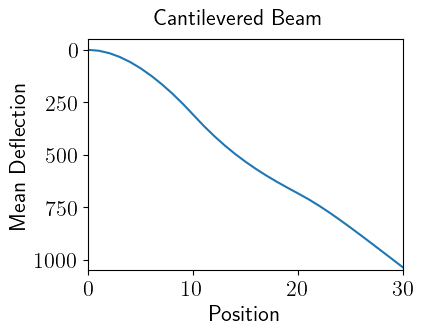

In [5]:
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(best_solution,'-')
ax.set_xlim([0,len(best_solution)-1]); ax.set_xlabel('Position')
ax.set_ylim([1050,-50]);  ax.set_ylabel('Mean Deflection');
ax.set_aspect(0.02)
fig.suptitle('Cantilevered Beam')
fig.savefig(figpath+'cantileveredbeamwords.eps',format='eps',bbox_inches='tight')

## Plots of IID and Low Discrepancy (LD) Points
These plots show how LD points fill space better than IID points.
### Lattice points first

[[0.05387361 0.83544624 0.76274187 ... 0.76038777 0.4065549  0.56548505]
 [0.55387361 0.33544624 0.26274187 ... 0.26038777 0.9065549  0.06548505]
 [0.30387361 0.58544624 0.51274187 ... 0.51038777 0.1565549  0.81548505]
 ...
 [0.78824861 0.91357124 0.96586687 ... 0.15101277 0.4846799  0.04986005]
 [0.53824861 0.16357124 0.21586687 ... 0.40101277 0.7346799  0.79986005]
 [0.03824861 0.66357124 0.71586687 ... 0.90101277 0.2346799  0.29986005]]


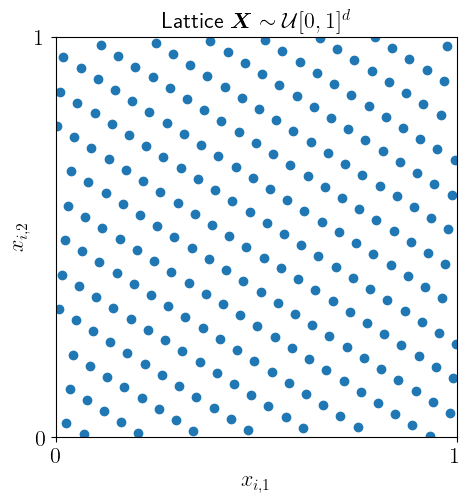

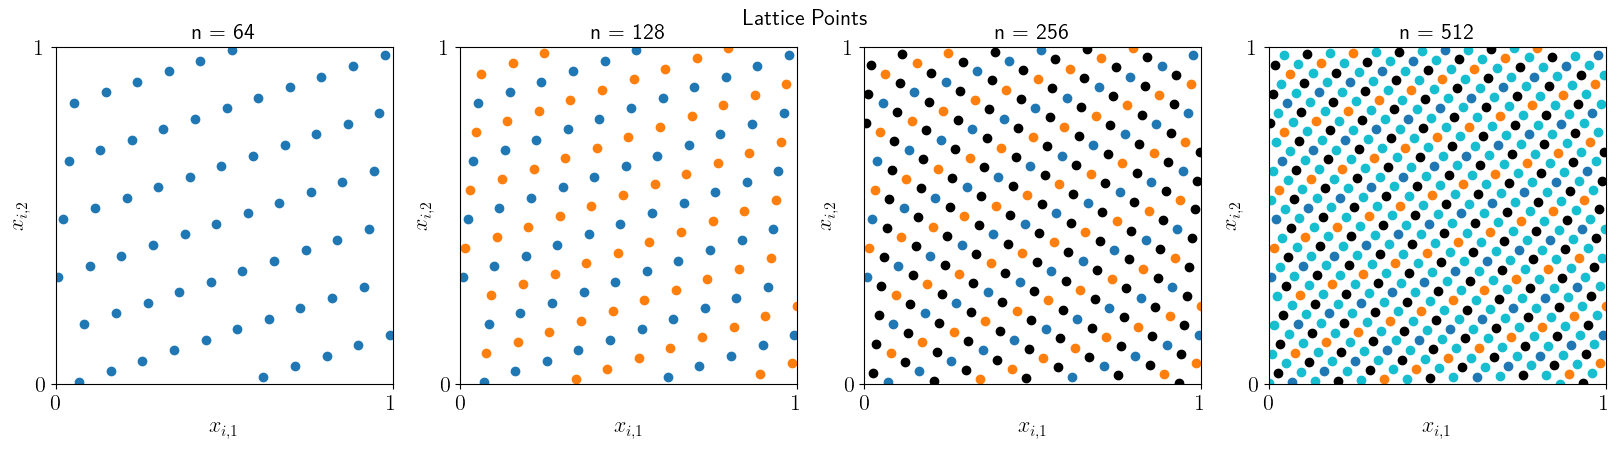

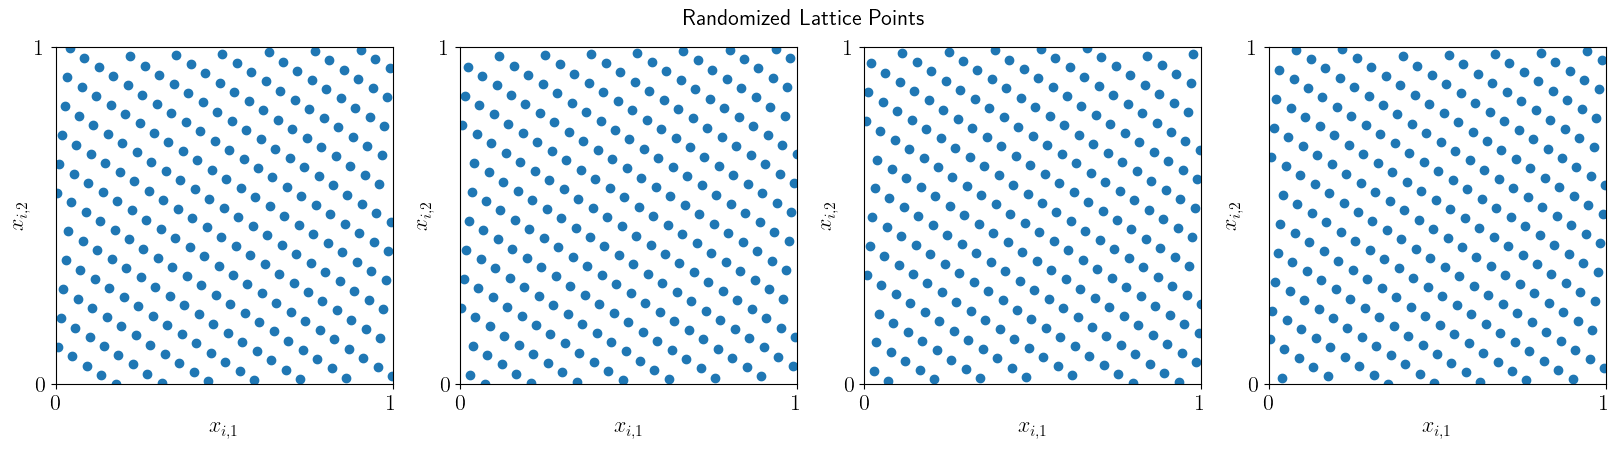

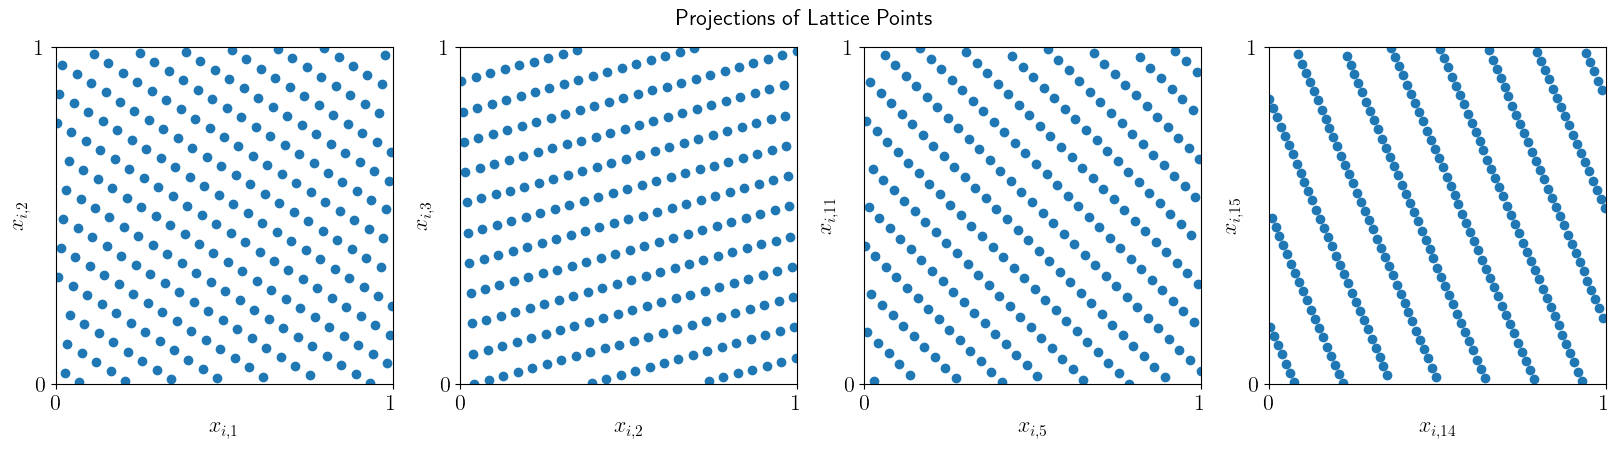

In [6]:
d = 15 #dimension
n = 64 #number of points
nrand = 4 #number of randomizations
coordlist=[[0,1],[1,2],[4,10],[13,14]]
ld = qp.Lattice(d) #define the generator
xpts = ld.gen_samples(n) #generate points
print(xpts)
fig = plot_successive_points(ld,'',first_n=4*n,n_cols=1,ntitle=False,titleText=r'Lattice $\boldsymbol{X} \sim \mathcal{U}[0,1]^d$')
plt.tight_layout() 
fig.savefig(figpath+'latticeptssingle.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Lattice',first_n=n,n_cols=4)
fig.savefig(figpath+'latticeptsseq.eps',format='eps',bbox_inches='tight')
ldrand = ld.spawn(nrand) #randomize
fig = plot_successive_points(ldrand,'Randomized Lattice',first_n=4*n,n_cols=nrand)
fig.savefig(figpath+'latticeptsrand.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Projections of Lattice',first_n=4*n,n_cols=nrand,coordlist=coordlist)
fig.savefig(figpath+'latticeptsproj.eps',format='eps',bbox_inches='tight')

### Next Sobol' points

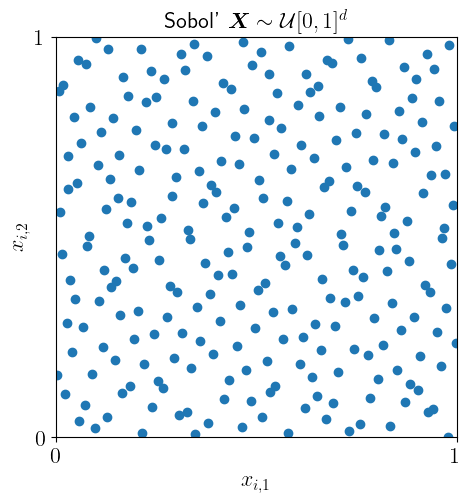

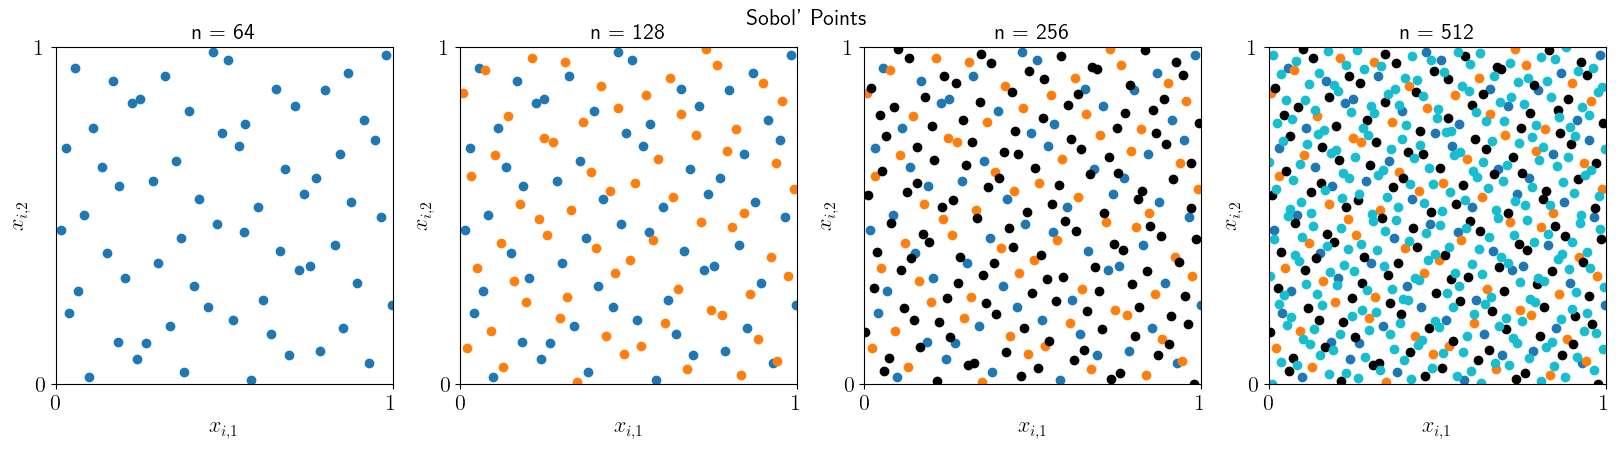

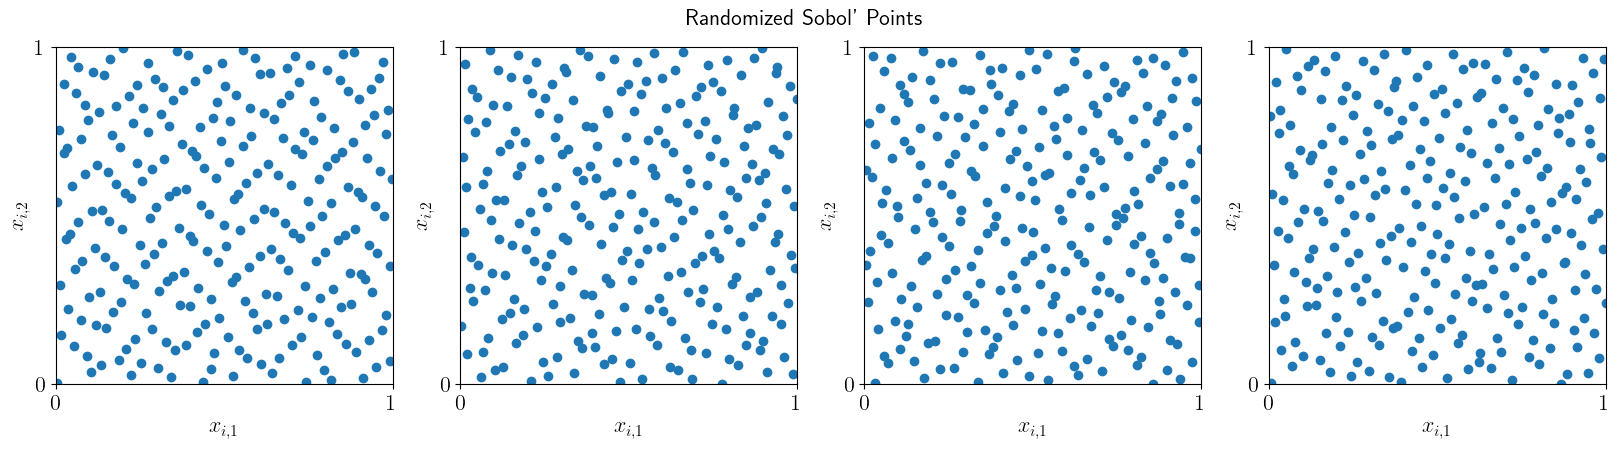

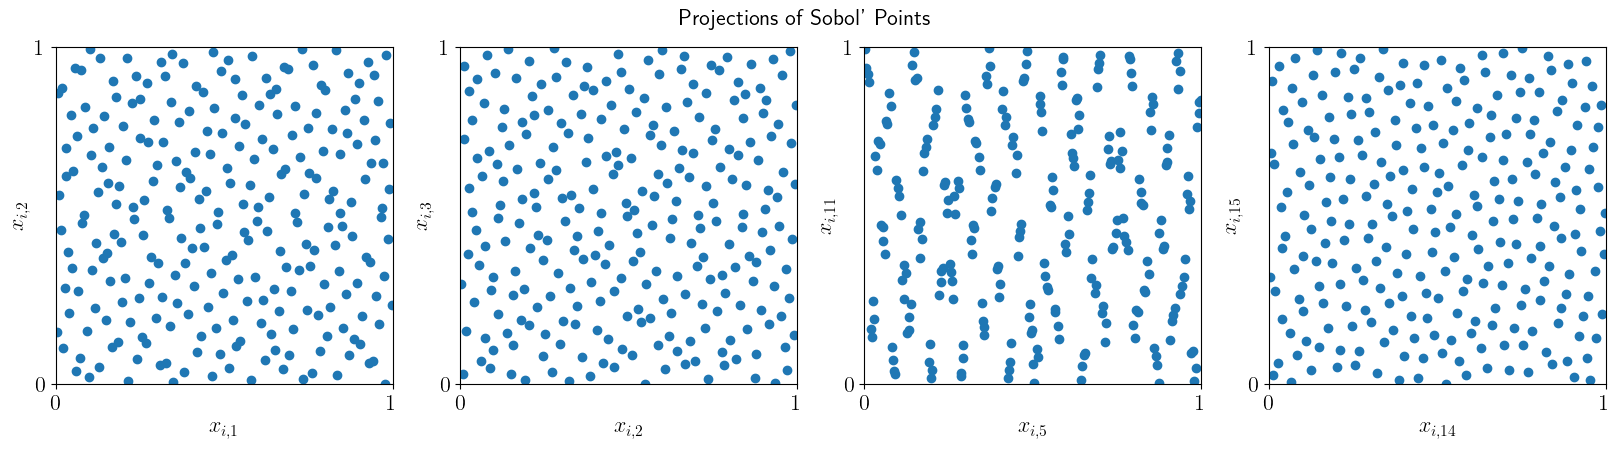

In [7]:
ld = qp.Sobol(d,seed=47) #define the generator
xpts_Sobol = ld.gen_samples(n) #generate points
fig = plot_successive_points(ld,'',first_n=4*n,n_cols=1,ntitle=False,titleText=r"Sobol' $\boldsymbol{X} \sim \mathcal{U}[0,1]^d$")
plt.tight_layout() 
fig.savefig(figpath+'sobolptssingle.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Sobol\'',first_n=n,n_cols=4)
fig.savefig(figpath+'sobolptsseq.eps',format='eps',bbox_inches='tight')
ldrand = ld.spawn(nrand) #randomize
fig = plot_successive_points(ldrand,'Randomized Sobol\'',first_n=4*n,n_cols=nrand)
fig.savefig(figpath+'sobolptsrand.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Projections of Sobol\'',first_n=4*n,n_cols=nrand,coordlist=coordlist)
fig.savefig(figpath+'sobolptsproj.eps',format='eps',bbox_inches='tight')

### Also Halton points

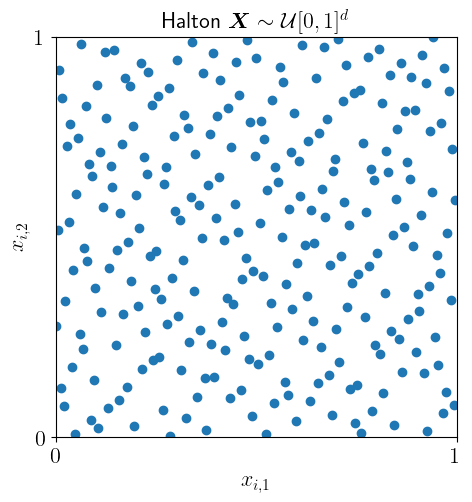

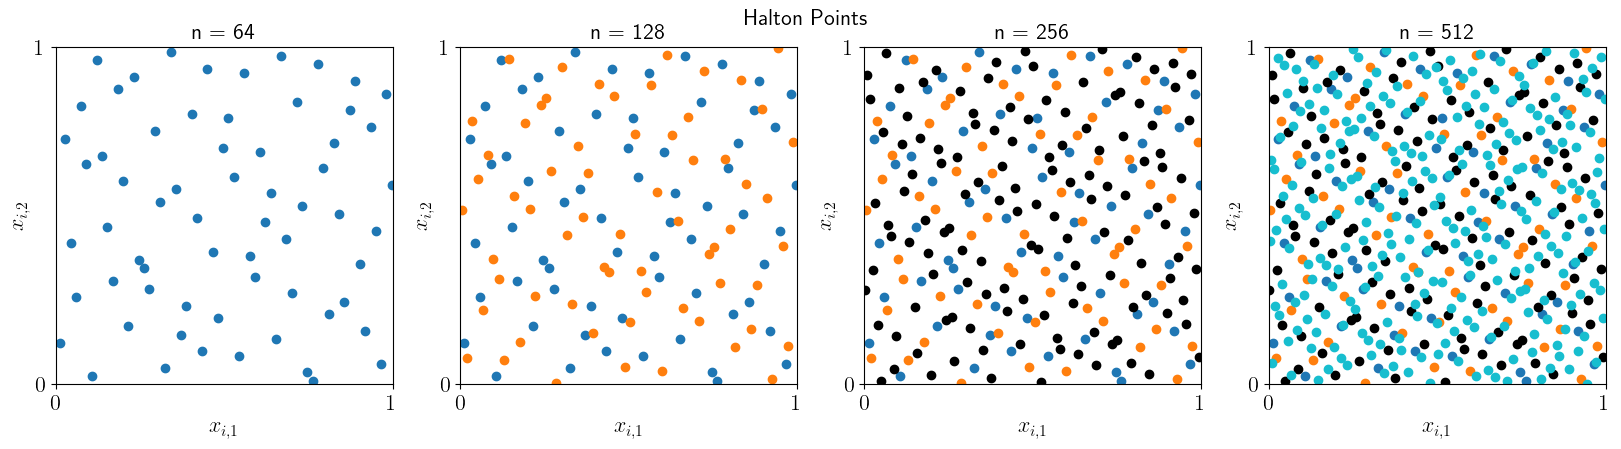

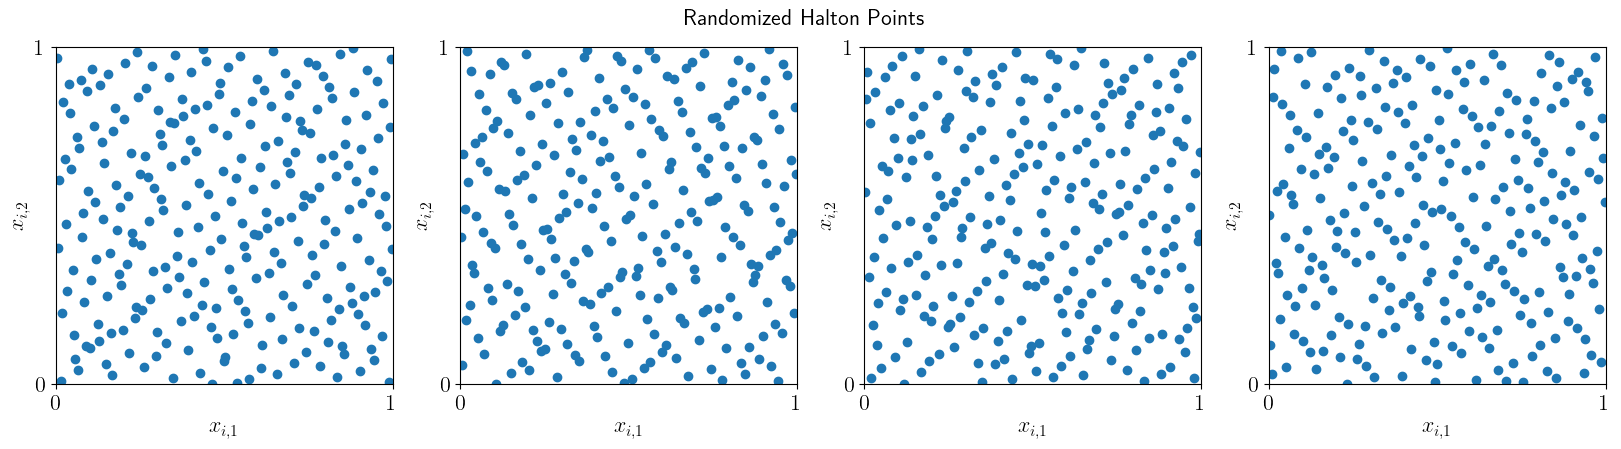

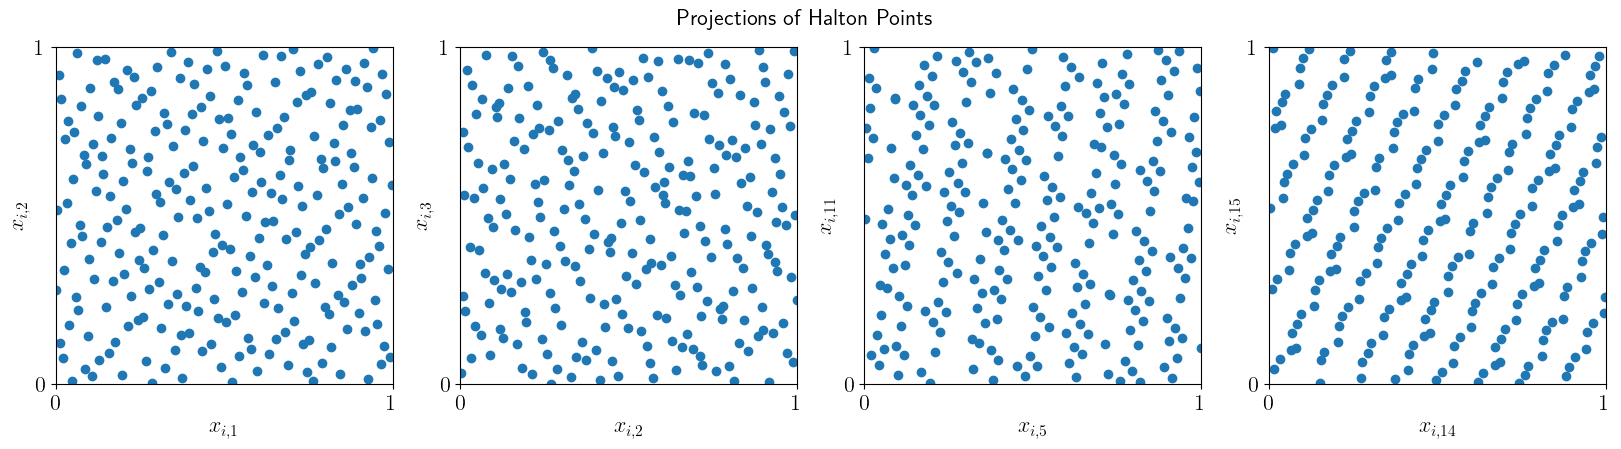

In [8]:
ld = qp.Halton(d) #define the generator
xpts_Halton = ld.gen_samples(n) #generate points
fig = plot_successive_points(ld,'',first_n=4*n,n_cols=1,ntitle=False,titleText=r'Halton $\boldsymbol{X} \sim \mathcal{U}[0,1]^d$')
plt.tight_layout() 
fig.savefig(figpath+'haltonptssingle.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Halton',first_n=n,n_cols=4)
fig.savefig(figpath+'haltonptsseq.eps',format='eps',bbox_inches='tight')
ldrand = ld.spawn(nrand) #randomize
fig = plot_successive_points(ldrand,'Randomized Halton',first_n=4*n,n_cols=nrand)
fig.savefig(figpath+'haltonptsrand.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(ld,'Projections of Halton',first_n=4*n,n_cols=nrand,coordlist=coordlist)
fig.savefig(figpath+'haltonptsproj.eps',format='eps',bbox_inches='tight')

### Compare to IID

Note that there are more gaps and clusters

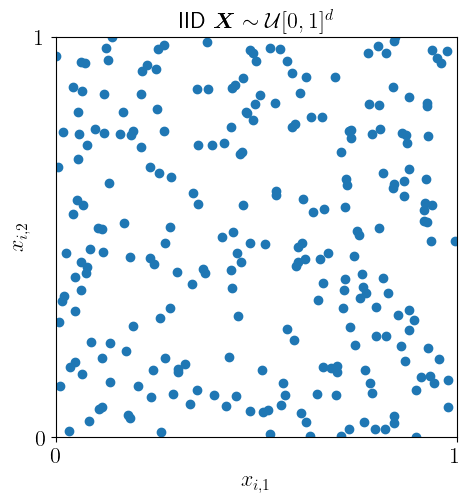

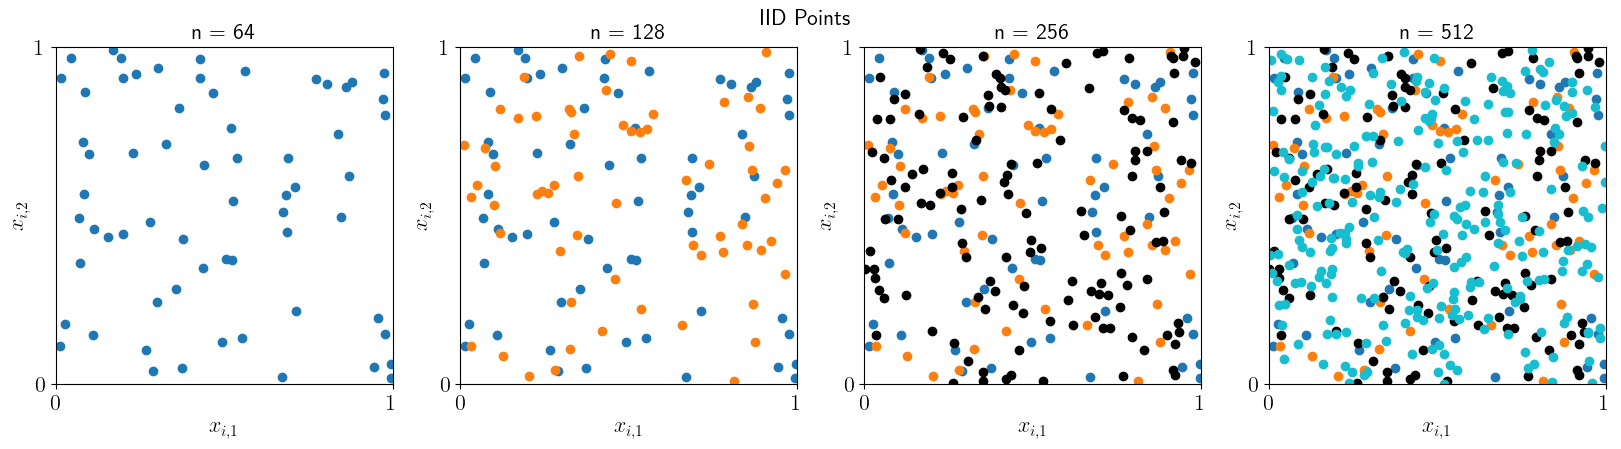

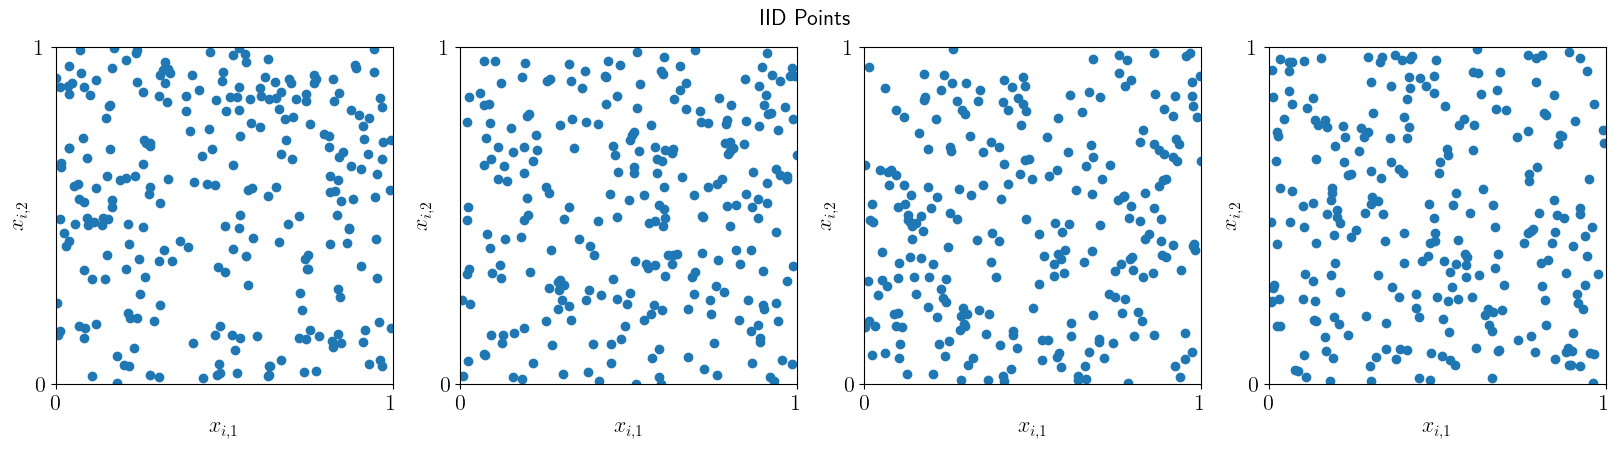

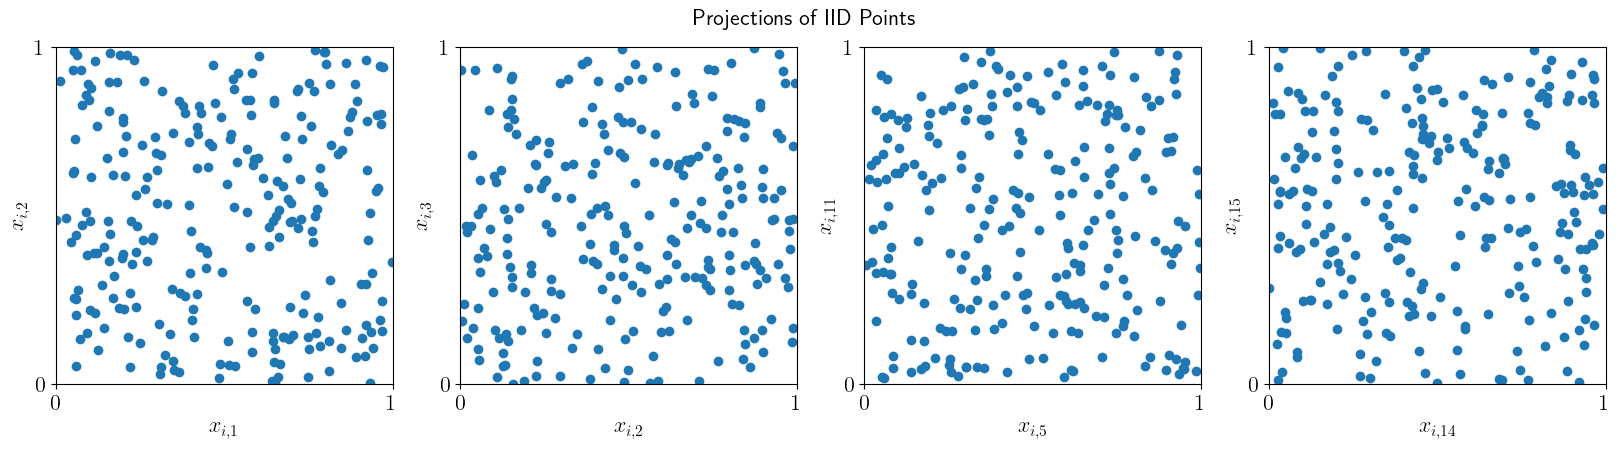

In [9]:
iid = qp.IIDStdUniform(d) #define the generator
xpts = ld.gen_samples(n) #generate points
xpts
fig = plot_successive_points(iid,'',first_n=4*n,n_cols=1,ntitle=False,titleText=r'IID $\boldsymbol{X}\sim\mathcal{U}[0,1]^d$')
plt.tight_layout() 
fig.savefig(figpath+'iidptssingle.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(iid,'IID',first_n=n,n_cols=4)
fig.savefig(figpath+'iidptsseq.eps',format='eps',bbox_inches='tight')
iidrand = iid.spawn(nrand) #randomize
fig = plot_successive_points(iidrand,'IID',first_n=4*n,n_cols=nrand)
fig.savefig(figpath+'iidptsrand.eps',format='eps',bbox_inches='tight')
fig = plot_successive_points(iid,'Projections of IID',first_n=4*n,n_cols=nrand,coordlist=coordlist)
fig.savefig(figpath+'iidptsproj.eps',format='eps',bbox_inches='tight')

In [10]:
qp.util.stop_notebook()

Type 'yes' to continue running notebook yes


*Below is long-running code that we rarely wish to run.*

## Beam Example Computations
### Set up the problem using a docker container to solve the ODE

To run this, you need to be running the docker application, https://www.docker.com/products/docker-desktop/

In [1]:
import umbridge #this is the connector
!docker run --name muqbp -d -it -p 4243:4243 linusseelinger/benchmark-muq-beam-propagation:latest #get beam example
d = 3 #dimension of the randomness
lb = 1 #lower bound on randomness
ub = 1.2 #upper bound on randomness
umbridge_config = {"d": d}
model = umbridge.HTTPModel('http://localhost:4243','forward') #this is the original model
outindex = -1 #choose last element of the vector of beam deflections
modeli = deepcopy(model) #and construct a model for just that deflection
modeli.get_output_sizes = lambda *args : [1]
modeli.get_output_sizes()
modeli.__call__ = lambda *args,**kwargs: [[model.__call__(*args,**kwargs)[0][outindex]]]

ModuleNotFoundError: No module named 'umbridge'

### First we compute the time required to solve for the deflection of the end point using IID and low discrepancy 

In [ ]:
ld = qp.Uniform(qp.Lattice(d,seed=7),lower_bound=lb,upper_bound=ub) #lattice points for this problem
ld_integ = qp.UMBridgeWrapper(ld,modeli,umbridge_config,parallel=False) #integrand
iid = qp.Uniform(qp.IIDStdUniform(d),lower_bound=lb,upper_bound=ub) #iid points for this problem
iid_integ = qp.UMBridgeWrapper(iid,modeli,umbridge_config,parallel=False) #integrand
tol = 0.01  #smallest tolerance

n_tol = 14  #number of different tolerances
ii_iid = 9  #make this larger to reduce the time required by not running all cases for IID
tol_vec = [tol*(2**ii) for ii in range(n_tol)]  #initialize vector of tolerances
ld_time = [0]*n_tol; ld_n = [0]*n_tol  #low discrepancy time and number of function values
iid_time = [0]*n_tol; iid_n = [0]*n_tol  #IID time and number of function values
print(f'\nCantilever Beam\n')
print('iteration ', end = '')
for ii in range(n_tol):
  solution, data = qp.CubQMCLatticeG(ld_integ, abs_tol = tol_vec[ii]).integrate()
  if ii == 0:
    best_solution_i = solution
  ld_time[ii] = data.time_integrate
  ld_n[ii] = data.n_total
  if ii >= ii_iid:
    solution, data = qp.CubMCG(iid_integ, abs_tol = tol_vec[ii]).integrate()
    iid_time[ii] = data.time_integrate
    iid_n[ii] = data.n_total
  print(ii, end = ' ')
with open(figpath+'iid_ld.pkl','wb') as myfile:pickle.dump([tol_vec,n_tol,ii_iid,ld_time,ld_n,iid_time,iid_n,best_solution_i],myfile)

### Next, we compute the time required to solve for the deflection of the whole beam using low discrepancy with and without parallel

In [ ]:
ld_integ = qp.UMBridgeWrapper(ld,model,umbridge_config,parallel=False) #integrand
ld_integ_p = qp.UMBridgeWrapper(ld,model,umbridge_config,parallel=8) #integrand with parallel processing

tol = 0.01
n_tol = 9  #number of different tolerances
tol_vec = [tol*(2**ii) for ii in range(n_tol)]  #initialize vector of tolerances
ld_time = [0]*n_tol; ld_n = [0]*n_tol  #low discrepancy time and number of function values
ld_p_time = [0]*n_tol; ld_p_n = [0]*n_tol  #low discrepancy time and number of function values with parallel
print(f'\nCantilever Beam\n')
print('iteration ', end = '')
for ii in range(n_tol):
  solution, data = qp.CubQMCLatticeG(ld_integ, abs_tol = tol_vec[ii]).integrate()
  if ii == 0:
    best_solution = solution
  ld_time[ii] = data.time_integrate
  ld_n[ii] = data.n_total
  solution, data = qp.CubQMCLatticeG(ld_integ_p, abs_tol = tol_vec[ii]).integrate()
  ld_p_time[ii] = data.time_integrate
  ld_p_n[ii] = data.n_total
  print(ii, end = ' ') 
with open(figpath+'ld_parallel.pkl','wb') as myfile:pickle.dump([tol_vec,n_tol,ld_time,ld_n,ld_p_time,ld_p_n,best_solution],myfile)

### Shut down docker

In [ ]:
!docker rm -f muqbp #shut down docker image